In [1]:
import os
import sys
import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

In [21]:
hands = {'rock': 0, 'paper': 1, 'scissors': 2, 'other': 3}

def oneHotEncode(labels, n_classes=4):
    return np.eye(n_classes, dtype=int)[labels]

# image data augmentation
def horizontalFlip(img):
    return cv2.flip(img, 1)

def verticalFlip(img):
    return cv2.flip(img, 0)

def grayScale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def rotate(img, angle):
    return cv2.rotate(img, angle)

In [22]:
def augment():
    for hand in hands.keys():
        for filename in os.listdir(hand):
            img = cv2.imread(os.path.join(hand, filename))
            filename = filename.split('.')[0]
            cv2.imwrite(filename=os.path.join(hand, "{}_hflip.jpg".format(filename)), img=horizontalFlip(img))
            cv2.imwrite(filename=os.path.join(hand, "{}_vflip.jpg".format(filename)), img=verticalFlip(img))
            cv2.imwrite(filename=os.path.join(hand, "{}_grayscale.jpg".format(filename)), img=grayScale(img))
            cv2.imwrite(filename=os.path.join(hand, "{}_rotate90cw.jpg".format(filename)), 
                img=rotate(img, cv2.ROTATE_90_CLOCKWISE))
            cv2.imwrite(filename=os.path.join(hand, "{}_rotate90ccw.jpg".format(filename)), 
                img=rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))


In [23]:
def preprocess():
    start = time.time()
    images = []
    labels = []
    for hand in hands.keys():
        for filename in os.listdir(hand):
            img = cv2.imread(os.path.join(hand, filename))
            img = cv2.resize(img, (227, 227))
            images.append(img)
            labels.append(hands[hand])
    labels = oneHotEncode(labels)
    end = time.time()
    print("time taken for preprocessing and labelling", end - start)
    return np.array(images), labels

In [24]:
x = np.array([[[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3]], [[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3]]])
# x.concatenate([[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3]])
x.shape

(4, 3, 3)

In [25]:
# augment()

In [26]:
images, labels = preprocess()

time taken for preprocessing and labelling 45.73922896385193


In [33]:
labels.shape

(12000, 4)

In [72]:
# df = pd.DataFrame(columns=['image', 'label'])
# df['image'] = images
# df['label'] = labels

In [52]:
# df2 = pd.DataFrame(columns = ['A','B','C'])
# df2['A'] = np.array(['hello', 'there', 'man'])
# df2['B'] = ['a', 'b', 'c']
# df2['C'] = np.array([[1, 2, 3],[4,5,6], [7,8,9]]).tolist()
# df2

In [8]:
df = df.sample(frac=1, axis=0).reset_index(drop=True)
df.head(25)

,image,label
0,"[[[88, 7, 147], [89, 6, 151], [85, 8, 145], [8...","[0, 0, 1, 0]"
1,"[[[74, 13, 145], [71, 15, 142], [69, 16, 138],...","[0, 1, 0, 0]"
2,"[[[46, 46, 46], [47, 47, 47], [45, 45, 45], [4...","[0, 0, 1, 0]"
3,"[[[78, 13, 143], [74, 14, 140], [70, 17, 138],...","[0, 0, 1, 0]"
4,"[[[82, 12, 143], [79, 9, 149], [81, 13, 146], ...","[0, 0, 0, 1]"
5,"[[[77, 13, 141], [79, 9, 149], [82, 8, 149], [...","[0, 0, 0, 1]"
6,"[[[74, 13, 143], [83, 9, 147], [85, 9, 149], [...","[0, 1, 0, 0]"
7,"[[[83, 12, 142], [77, 14, 141], [74, 15, 141],...","[0, 0, 1, 0]"
8,"[[[74, 12, 145], [87, 8, 152], [91, 8, 147], [...","[0, 0, 0, 1]"
9,"[[[79, 12, 144], [78, 11, 144], [71, 15, 142],...","[0, 1, 0, 0]"


In [36]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(images, labels, test_size=0.15, shuffle=True)

In [11]:
df_train['image'][0].shape

(227, 227, 3)

In [ ]:
# Xtrain = df_train['image'].tolist()
# Ytrain = df_train['label'].tolist()
# # train = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain))

# Xtest = df_test['image'].tolist()
# Ytest = df_test['label'].tolist()
# # test = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))


In [40]:
print(Ytest.shape)
print(Xtrain[0][0][0][0])

(1800, 4)
85


In [46]:
# build model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(227,227,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [47]:
history = model.fit(x=Xtrain, y=Ytrain, epochs=3)

Epoch 1/3
319/319 [==============================] - 798s 3s/step - loss: 5.9817 - accuracy: 0.5699
Epoch 2/3
319/319 [==============================] - 795s 2s/step - loss: 0.4812 - accuracy: 0.9224
Epoch 3/3
319/319 [==============================] - 817s 3s/step - loss: 1.0398 - accuracy: 0.9625


In [48]:
model.evaluate(x=Xtest, y=Ytest)

57/57 [==============================] - 35s 622ms/step - loss: 0.0247 - accuracy: 0.9961


[0.024742506444454193, 0.9961110949516296]

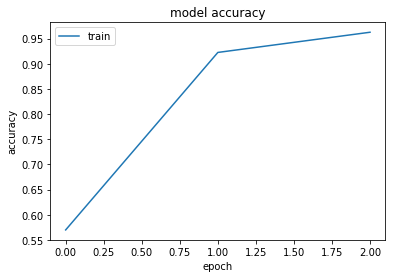

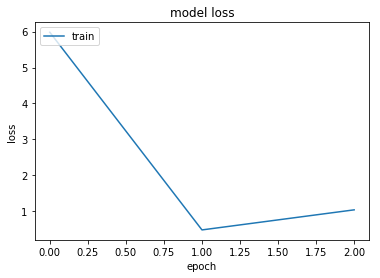

In [53]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
model.save("rps_model.h5")

In [71]:
x = Xtest[1]
y = Ytest[1]
# print(np.array([x]))
model.predict(np.asarray([x]))

array([[1.0000000e+00, 1.6178163e-11, 1.3374531e-16, 1.7732976e-24]],
      dtype=float32)